# 线性回归的从零开始实现

In [54]:
%matplotlib inline
import random
import torch
import numpy as np
from d2l import torch as d2l

def synthetic_data(w,b,num_examples): #@save
    '''生成y = Xw + b + 噪声'''
    X = torch.normal(0, 1, (num_examples,len(w))) #均值为0，标准差为1，样本特征为(num_examples,len(w))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) #添加噪声
    return X , y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [55]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.0382, -0.3790]) 
label: tensor([5.4200])


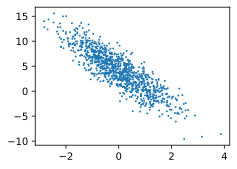

In [56]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),s = 1)

In [57]:
def data_iter(batch_size,features,labels):
    num_example = len(features)
    indices = list(range(num_example))
    #这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0,num_example,batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size,num_example)]
        )
        # yield 是 Python 中生成器的关键字，它会在每次迭代时返回一批数据，但不会像 return 
        # 那样终止函数。生成器函数会记住它的状态，并在下一次调用时从上次停止的地方继续执行。
        yield features[batch_indices],labels[batch_indices]

In [58]:
batch_size = 10
for X, y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 1.5704, -0.0151],
        [-1.6156,  0.3008],
        [ 0.2886,  0.5079],
        [ 0.4769, -1.1420],
        [-1.3274,  0.2825],
        [-0.4821, -0.6594],
        [ 0.3507,  0.3859],
        [ 0.4339, -1.9937],
        [ 1.4048, -1.2975],
        [-0.9711,  0.7220]]) 
 tensor([[ 7.3717],
        [-0.0561],
        [ 3.0463],
        [ 9.0347],
        [ 0.5902],
        [ 5.4764],
        [ 3.5756],
        [11.8395],
        [11.4302],
        [-0.1797]])


In [59]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [60]:
def linreg(X ,w ,b): #@save
    '''线性回归模型'''
    return torch.matmul(X,w) + b

In [61]:
def squared_loss(y_hat,y): #@save
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [62]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [63]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) #X和y的小批量损失
        #因为l形状是（batch_size,1),而不是一个标量，l中的所有元素被加到一起
        #并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1},loss{float(train_l.mean()):f}')

epoch 1,loss0.046329
epoch 2,loss0.000199
epoch 3,loss0.000051


In [64]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) #X和y的小批量损失
        #因为l形状是（batch_size,1),而不是一个标量，l中的所有元素被加到一起
        #并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1},loss{float(train_l.mean()):f}')

epoch 1,loss0.000050
epoch 2,loss0.000051
epoch 3,loss0.000050


In [65]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([-7.6532e-05, -9.4414e-05], grad_fn=<SubBackward0>)
b的估计误差:tensor([-8.1539e-05], grad_fn=<RsubBackward1>)


## 练习

In [66]:
import torch

#生成数据
x = torch.randn(100,1)
y = 30 * x

#定义模型
model = torch.nn.Linear(1,1)

#定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

for epoch in range(500):
    #前向传播
    y_pred = model(x)

    #计算损失
    loss = criterion(y_pred,y)

    #反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(model.weight)
print(model.bias)

Parameter containing:
tensor([[29.9873]], requires_grad=True)
Parameter containing:
tensor([0.0029], requires_grad=True)


尝试使用不同的学习率，观察损失函数值下降的快慢

In [67]:
lrs = [0.5,0.3,0.1,0.01]
num_epochs = 10
net = linreg
loss = squared_loss

batch_size = 10

all_lrs = []
for lr in lrs:
    train_lrs = []
    for epoch in range(num_epochs):
        for X,y in data_iter(batch_size,features,labels):
            l = loss(net(X,w,b),y) #X和y的小批量损失
            #因为l形状是（batch_size,1),而不是一个标量，l中的所有元素被加到一起
            #并以此计算关于[w,b]的梯度
            l.sum().backward()
            sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
        with torch.no_grad():
            train_l = loss(net(features,w,b),labels)
            train_lrs.append(float(train_l.mean()))
    all_lrs.append(train_lrs)

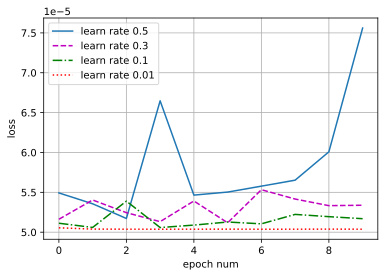

In [74]:
epochs = np.arange(num_epochs + 1,1)
d2l.plot(epochs,all_lrs,xlabel='epoch num',ylabel='loss',
         legend = [f'learn rate {lr}' for lr in lrs],
         figsize = (6,4))

如果样本个数不能被批量大小整除，那么会忽略最后一个批次中多余的样本